# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [60]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns

In [61]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [62]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [63]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [64]:
print(dataset['Score'].value_counts() )                                 # Printing the number of positive and negative reviews
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.head()

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [65]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [66]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [67]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [68]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

In [69]:
# Getting the number of positive and negative reviews

data['Score'].value_counts()

Positive    307026
Negative     57105
Name: Score, dtype: int64

### 2.2 Data Cleaning

In [70]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [71]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [72]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [73]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [74]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{'where', 'down', 'be', 'own', "wasn't", 'ours', 've', 'does', 'doing', 'this', 'off', 'her', 'hasn', 'we', 'after', 'before', 'more', 'above', 'the', "don't", 'no', "didn't", 'most', 'yourself', 'were', 'not', 'who', 'been', 'through', 'yours', 'isn', 'these', 're', 'having', 'd', 'all', 'an', 'o', 'as', 'won', 'is', 'they', 'until', 'which', 'in', 'into', 'it', "you're", 'you', 'hadn', 'its', 'again', 'each', 'same', 's', 'wouldn', "you'll", "hasn't", 'mustn', 'below', 'haven', 'whom', 'couldn', 'needn', 'ma', 'didn', 'his', 'had', 'so', 'ain', 'themselves', "hadn't", "won't", 'hers', 'under', 'y', 'while', 'mightn', 'theirs', 'and', 'with', 'very', 'your', 'weren', "weren't", 'can', 'too', "should've", 'did', "mightn't", 'up', 'myself', 'only', 'than', 'out', 'll', "haven't", 'him', 'about', "needn't", "shouldn't", 'ourselves', 'by', 'from', "isn't", "wouldn't", 'there', 'during', "you've", 'against', 'how', 'shan', 'such', 'are', 'when', "that'll", 'their', 'them', 'other', 'some',

In [75]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [76]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [77]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in data['Text'].values:
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

In [78]:
data['CleanedText'] = final_str                                    # Adding a column in dataset and storing cleaned text in it.
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [79]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [80]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [81]:
# Splitting data into Train, Test and Cross-validation

x_train = time_sort[:203912]
x_cv = time_sort[203912:291304]
x_test = time_sort[291304:]

y_train = x_train['Score']
y_cv = x_cv['Score']
y_test = x_test['Score']

In [82]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (203912, 11) (203912,)
The shape of the CV data is: (87392, 11) (87392,)
The shape of the test data is: (72827, 11) (72827,)


# 4. Vectorization of splitted of data

### 4.1 Bag of Words (BoG)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
count_vect = CountVectorizer()
count_vect.fit(x_train['CleanedText'])
# Fit should be done only to train data
# After fitting count_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train['CleanedText'])
x_cv_bow = count_vect.transform(x_cv['CleanedText'])
x_test_bow = count_vect.transform(x_test['CleanedText'])

In [26]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (203912, 67290) (203912,)
The shape of the CV data is: (87392, 67290) (87392,)
The shape of the test data is: (72827, 67290) (72827,)


### 4.2 Bi-grams, Tri-grams and n-grams

In [27]:
from nltk import FreqDist

In [28]:
# Stop words like "not" should not be removed before building n-grams

frequently_occuring_positives = FreqDist(positive_words)
frequently_occuring_negatives = FreqDist(negative_words)

In [29]:
print("Most common positive words: \n", frequently_occuring_positives.most_common(20))
print("=="*60)
print("Most common negative words: \n", frequently_occuring_negatives.most_common(20))

Most common positive words: 
 [(b'like', 139075), (b'tast', 128126), (b'good', 111583), (b'flavor', 108443), (b'love', 106975), (b'use', 103603), (b'great', 103140), (b'one', 95883), (b'product', 90263), (b'tri', 86373), (b'tea', 82532), (b'coffe', 77564), (b'make', 74906), (b'get', 71918), (b'food', 63848), (b'would', 55470), (b'time', 54822), (b'buy', 54012), (b'realli', 52584), (b'eat', 51726)]
Most common negative words: 
 [(b'tast', 34265), (b'like', 32215), (b'product', 27865), (b'one', 20395), (b'flavor', 19060), (b'would', 17955), (b'tri', 17688), (b'use', 15229), (b'good', 14801), (b'coffe', 14405), (b'get', 13756), (b'buy', 13701), (b'order', 12820), (b'food', 12521), (b'tea', 11421), (b'even', 11040), (b'box', 10745), (b'make', 9815), (b'time', 9729), (b'bag', 9650)]


In [30]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigrams_count = count_vect.fit_transform(data['CleanedText'].values)

final_bigrams_count.get_shape()

(364131, 2923576)

### 4.3 Term frequency - Inverse document frequency (tf-idf)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(x_train['CleanedText'])
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train['CleanedText'])
x_cv_tfidf = tfidf_vect.transform(x_cv['CleanedText'])
x_test_tfidf = tfidf_vect.transform(x_test['CleanedText'])

In [33]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (203912, 67290) (203912,)
The shape of the CV data is: (87392, 67290) (87392,)
The shape of the test data is: (72827, 67290) (72827,)


# 5. Applying KNN Brute Force to vectorized data

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

### 5.1 KNN Brute Force on BoW

In [50]:
# This may take a several minutes(even hours) to execute

for k in range(6, 15, 2):                                               # Initializing learning model with k=4 to k=15 with step-seze=2
    neighbor = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    neighbor.fit(x_train_bow, y_train)                                  # Fitting training data to the model
    prediction = neighbor.predict(x_cv_bow)

    print("FOR K =", k)
    print("The accuracy of the model is:", accuracy_score(y_cv, prediction)*100)
    print("The f1_score of the model is:", np.round(f1_score(y_cv, prediction, average='macro')*100))
    print("The precision_score of the model is:", np.round(precision_score(y_cv, prediction, average='macro')*100))
    print("The recall_score of the model is:", np.round(recall_score(y_cv, prediction, average='macro')*100))
    print("=="*60)

FOR K = 6
The accuracy of the model is: 83.23874038813621
The f1_score of the model is: 59.0
The precision_score of the model is: 72.0
The recall_score of the model is: 58.0
FOR K = 8
The accuracy of the model is: 83.36461003295497
The f1_score of the model is: 57.0
The precision_score of the model is: 74.0
The recall_score of the model is: 56.0
FOR K = 10
The accuracy of the model is: 83.37033138044673
The f1_score of the model is: 55.0
The precision_score of the model is: 76.0
The recall_score of the model is: 55.0
FOR K = 12
The accuracy of the model is: 83.27535701208349
The f1_score of the model is: 54.0
The precision_score of the model is: 77.0
The recall_score of the model is: 54.0
FOR K = 14
The accuracy of the model is: 83.21928780666423
The f1_score of the model is: 53.0
The precision_score of the model is: 78.0
The recall_score of the model is: 54.0


In [52]:
from scikitplot.metrics import plot_confusion_matrix

The value of k with highest accuracy is k = 10
The accuracy of the model is: 83.78486001071032
The f1_score of the model is: 55.0
The precision_score of the model is: 76.0
The recall_score of the model is: 55.0


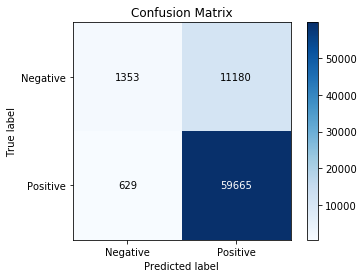

In [53]:
neighbor = KNeighborsClassifier(n_neighbors=10, algorithm='brute')
neighbor.fit(x_train_bow, y_train)
prediction = neighbor.predict(x_test_bow)

print("The value of k with highest accuracy is k = 10")
print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
print("The f1_score of the model is:", np.round(f1_score(y_test, prediction, average='macro')*100))
print("The precision_score of the model is:", np.round(precision_score(y_test, prediction, average='macro')*100))
print("The recall_score of the model is:", np.round(recall_score(y_test, prediction, average='macro')*100))
plot_confusion_matrix(y_test, prediction)
plt.show()

### 5.2 KNN Brute Force on tf-idf

In [54]:
# This may take a several minutes to execute

for k in range(4, 15, 2):                                                 # Initializing learning model with k=4 to k=15 with step-seze=2
    neighbor = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    neighbor.fit(x_train_tfidf, y_train)                                  # Fitting training data to the model
    prediction = neighbor.predict(x_cv_tfidf)

    print("FOR K =", k)
    print("The accuracy of the model is:", accuracy_score(y_cv, prediction)*100)
    print("The f1_score of the model is:", np.round(f1_score(y_cv, prediction, average='macro')*100))
    print("The precision_score of the model is:", np.round(precision_score(y_cv, prediction, average='macro')*100))
    print("The recall_score of the model is:", np.round(recall_score(y_cv, prediction,scikitplot average='macro')*100))
    print("=="*60)

FOR K = 4
The accuracy of the model is: 83.33371475649946
The f1_score of the model is: 63.0
The precision_score of the model is: 71.0
The recall_score of the model is: 61.0
FOR K = 6
The accuracy of the model is: 84.19649395825705
The f1_score of the model is: 62.0
The precision_score of the model is: 75.0
The recall_score of the model is: 60.0
FOR K = 8
The accuracy of the model is: 84.4013181984621
The f1_score of the model is: 61.0
The precision_score of the model is: 78.0
The recall_score of the model is: 59.0
FOR K = 10
The accuracy of the model is: 84.43907909190773
The f1_score of the model is: 60.0
The precision_score of the model is: 80.0
The recall_score of the model is: 58.0
FOR K = 12
The accuracy of the model is: 84.3292292200659
The f1_score of the model is: 59.0
The precision_score of the model is: 80.0
The recall_score of the model is: 58.0
FOR K = 14
The accuracy of the model is: 84.31778652508238
The f1_score of the model is: 59.0
The precision_score of the model is:

In [55]:
from scikitplot.metrics import plot_confusion_matrix

The value of k with highest accuracy is k = 10
The accuracy of the model is: 84.6609087289055
The f1_score of the model is: 60.0
The precision_score of the model is: 79.0
The recall_score of the model is: 58.0


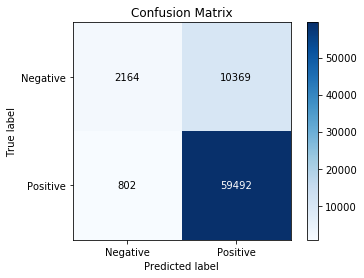

In [56]:
neighbor = KNeighborsClassifier(n_neighbors=10, algorithm='brute')
neighbor.fit(x_train_tfidf, y_train)
prediction = neighbor.predict(x_test_tfidf)

print("The value of k with highest accuracy is k = 10")
print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
print("The f1_score of the model is:", np.round(f1_score(y_test, prediction, average='macro')*100))
print("The precision_score of the model is:", np.round(precision_score(y_test, prediction, average='macro')*100))
print("The recall_score of the model is:", np.round(recall_score(y_test, prediction, average='macro')*100))
plot_confusion_matrix(y_test, prediction)
plt.show()